# Query Google Maps Satellite Tiles from Given Coordinates and Zoom Level

Functions to retrieve Google Maps satellite tiles (256x256 RGB images) from specified longitudes, latitudes, and zoom levels.

Objectives:
- Retrieve the tile at a specified zoom level that covers a user-specified (longitude, latitude)
- Correctly georeference the tile (bounds of the tile, coordinates of the center of every pixel/mesh)

Preliminary work for a computer vision project...

Cyril Joly

In [1]:
from io import BytesIO

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import requests
import rioxarray as rio
import xarray as xr
from geometry_utils import encode_dataset, get_coordinates
from PIL import Image
from shapely.geometry import box


class GoogleMapsTiles:
    @staticmethod
    def tile_coords_to_lon_lat(zoom, xtile, ytile):
        n = 1 << zoom
        lon = xtile / n * 360 - 180
        lat_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
        lat = np.degrees(lat_rad)
        return lat, lon

    @staticmethod
    def lon_lat_to_tile_coords(zoom, lon, lat):
        n = 2 ** zoom
        xtile = n * ((lon + 180) / 360)
        lat_rad = np.pi / 180 * lat
        ytile = n * (1 - (np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi)) / 2
        return np.floor(xtile).astype(int), np.floor(ytile).astype(int)

    @classmethod
    def get_tile_mesh(cls, zoom, xtile, ytile):
        ymax, xmin = cls.tile_coords_to_lon_lat(zoom, xtile, ytile)
        ymin, xmax = cls.tile_coords_to_lon_lat(zoom, xtile+1, ytile+1)
        dx = (xmax-xmin)/256
        dy = (ymax-ymin)/256
        x = xmin + dx*np.arange(256)
        y = ymin + dy*np.arange(256)
        return x, y

    @staticmethod
    def url_tile(zoom, xtile, ytile) -> str:
        return f'https://mt1.google.com/vt/lyrs=s&x={xtile}&y={ytile}&z={zoom}'

    @classmethod
    def url_from_lon_lat(cls, zoom, lon, lat) -> (int, int, str):
        xtile, ytile = cls.lon_lat_to_tile_coords(zoom=zoom, lon=lon, lat=lat)
        return xtile, ytile, cls.url_tile(zoom, xtile, ytile)

    @staticmethod
    def url_to_numpy_array(url) -> np.ndarray:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content))
        image_array = np.array(image)
        return image_array

    @classmethod
    def download_raster(cls, zoom, place=None, lon=None, lat=None, xtile=None, ytile=None):
        if isinstance(place, str):
            lon_, lat_ = get_coordinates(place=place)
            xtile_, ytile_, url = cls.url_from_lon_lat(zoom=zoom, lon=lon_, lat=lat_)
            tile = cls.url_to_numpy_array(url)
        elif isinstance(lon, float) and isinstance(lat, float):
            xtile_, ytile_, url = cls.url_from_lon_lat(zoom=zoom, lon=lon, lat=lat)
            tile = cls.url_to_numpy_array(url)
        elif isinstance(lon, float) and isinstance(lat, float):
            xtile_, ytile_ = xtile, ytile
            tile = cls.url_to_numpy_array(cls.url_tile(zoom=zoom, xtile=xtile, ytile=ytile))
        x, y = cls.get_tile_mesh(zoom=zoom, xtile=xtile_, ytile=ytile_)
        ds = xr.Dataset({'red': (('y', 'x'), np.flip(tile[:, :, 0], axis=0)),
                         'green': (('y', 'x'), np.flip(tile[:, :, 1], axis=0)),
                         'blue': (('y', 'x'), np.flip(tile[:, :, 2], axis=0))},
                        coords={'y': ('y', y), 'x': ('x', x)})
        encode_dataset(ds, crs=4326)
        return ds

    @staticmethod
    def plot_raster(ds, figsize=None, gdf=None, show=True):
        x = ds.x.values
        y = ds.y.values
        dx, dy = np.diff(x)[0], np.diff(y)[0]
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        im = np.stack([ds['red'].values, ds['green'].values, ds['blue'].values], axis=-1)
        plt.figure(figsize=figsize)
        plt.imshow(im, extent=(xmin-dx/2, xmax+dx/2, ymin-dy/2, ymax+dy/2), origin='lower')
        plt.xlim(xmin-dx/2, xmax+dx/2)
        plt.ylim(ymin-dy/2, ymax+dy/2)
        plt.gca().axis('off')
        plt.gca().set_aspect(1/np.cos(y.mean()*np.pi/180))
        if gdf is not None:
            gpd.clip(gdf, mask=(xmin-dx/2, ymin-dy/2, xmax+dx/2, ymax+dy/2)).plot(ax=plt.gca(), fc='none', lw=1)
        if show:
            plt.show()

In [2]:
paris = gpd.read_file("https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson?lang=fr&timezone=Europe%2FBerlin")
osm_roads = gpd.read_file("data/osm_roads_paris.gpkg")

In [3]:
ds = GoogleMapsTiles.download_raster(zoom=12, place='Paris, France')
ds.rio.to_raster('tile_test.tif')
ds

<xarray.Dataset> Size: 199kB
Dimensions:      (y: 256, x: 256)
Coordinates:
  * y            (y) float32 1kB 48.81 48.81 48.81 48.81 ... 48.86 48.86 48.86
  * x            (x) float32 1kB 2.285 2.285 2.286 2.286 ... 2.372 2.372 2.373
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) uint8 66kB 120 101 104 97 121 ... 117 120 116 128 111
    green        (y, x) uint8 66kB 114 95 101 94 120 114 ... 122 124 120 134 117
    blue         (y, x) uint8 66kB 100 81 84 75 100 92 ... 118 123 119 132 115

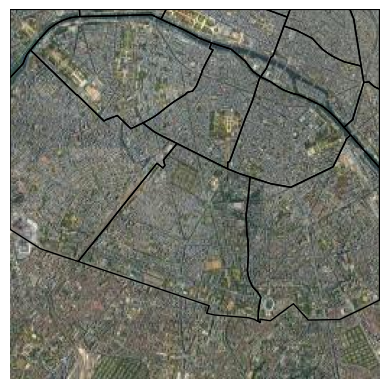

In [4]:
GoogleMapsTiles.plot_raster(ds, gdf=paris)

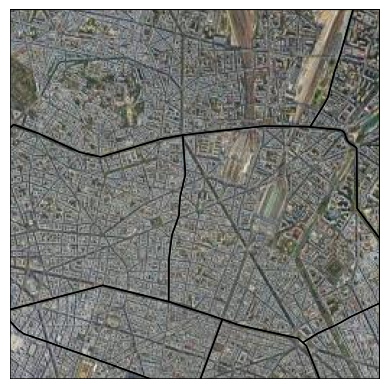

In [5]:
ds = GoogleMapsTiles.download_raster(zoom=13, place='Sacré Coeur, Paris')
GoogleMapsTiles.plot_raster(ds, gdf=paris)

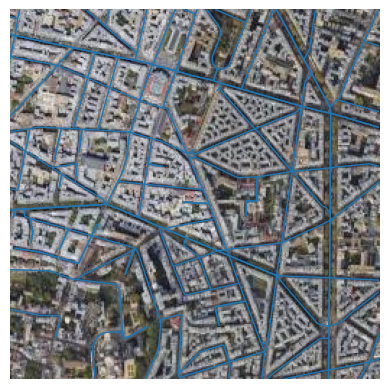

In [6]:
ds = GoogleMapsTiles.download_raster(zoom=15, place='Sacré Coeur, Paris')
GoogleMapsTiles.plot_raster(ds, gdf=osm_roads)

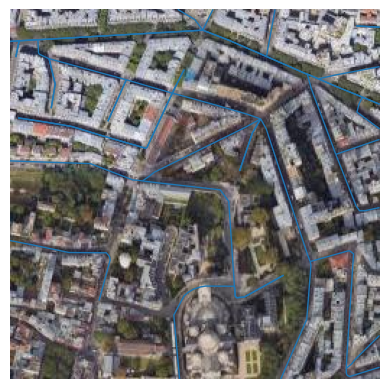

In [7]:
ds = GoogleMapsTiles.download_raster(zoom=16, place='Sacré Coeur, Paris')
GoogleMapsTiles.plot_raster(ds, gdf=osm_roads)

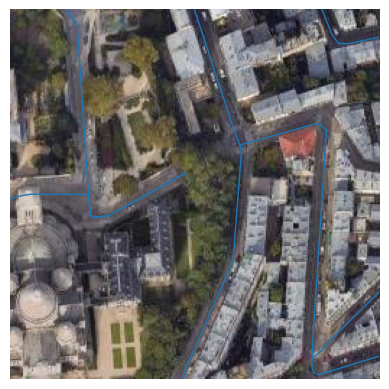

In [8]:
ds = GoogleMapsTiles.download_raster(zoom=17, place='Sacré Coeur, Paris')
GoogleMapsTiles.plot_raster(ds, gdf=osm_roads)

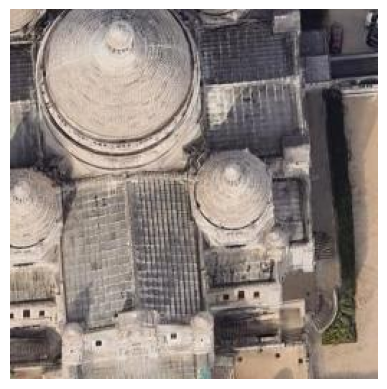

In [9]:
ds = GoogleMapsTiles.download_raster(zoom=19, place='Sacré Coeur, Paris')
GoogleMapsTiles.plot_raster(ds)